Below is the demo of my current tech for comparison of color used in inspirational images and the final submission. Currently my approahc is to convert image to it HSV form, calculate their hue histogram to see the distribution of colors, and calculate their saturation histograms to determine how much blacks and whites are there in those images. 
    
I calculate normalized wasserstein distance between hue histograms and between saturation histograms, and then i calculate weighetd mean of those results assigning 0.66 to the hue and 0.33 to the saturation. This way i hope to get a simmilarity measure that will accurately distinguish both colors and intensity of black and whites used. 
    
Wasserstein is a cost function, but since i use normalization i can easily turn it into normalized gain function by simply returning 1-wasserstain_distance.  

# Code stuff

## Load images

In [9]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import PIL
import os
import random
import re

from scipy.stats import wasserstein_distance
from typing import Literal

random.seed(156059)


def imshow(img):
    img = img.astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    display(PIL.Image.fromarray(img).convert("RGB"))


def imshow_on_axis(img, ax, title):
    img = img.astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.set_title(title, fontsize=18)
    ax.axis("off")


def load_images_from_path(path, number):
    images = []
    pattern = rf"^{number}(?!\d)"
    
    for filename in os.listdir(path):
        if re.match(pattern, filename):
            img = cv2.imread(os.path.join(path, filename))
            if img is not None:
                images.append(img)

    return images


def load_images(number):
    final_images = []

    final_path = f"data/final_submissions/{number}/"
    web_path = "data/web/"
    ai_path = "data/ai/"

    if not os.path.exists(final_path):
        print(f"The final submissions path '{final_path}' does not exist.")
        return None, None, None

    for filename in os.listdir(final_path):
        img = cv2.imread(os.path.join(final_path, filename))
        if img is not None:
            final_images.append(img)

    web_images = load_images_from_path(web_path, number)
    ai_images = load_images_from_path(ai_path, number)

    if not final_images:
        print(f"No images found in '{final_path}'. Please check the contents.")
        return None, None, None

    if not web_images and not ai_images:
        print(
            f"The number '{number}' does not correspond to any valid images in 'web' or 'ai' folders."
        )
        return None, None, None

    if not web_images:
        print(f"No web images found with prefix '{number}' in '{web_path}'.")
        return None, None, None
    if not ai_images:
        print(f"No AI images found with prefix '{number}' in '{ai_path}'.")
        return None, None, None

    return final_images, web_images, ai_images

## Color Histograms Indexing

### Hue histograms

In [10]:
def get_hue_histogram(image, num_buckets):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([image_hsv], [0], None, [num_buckets], [0, 180])

    hist = hist / np.sum(hist)

    return hist


def hue_to_rgb(hue):
    hsv_color = np.uint8([[[hue, 255, 255]]])
    rgb_color = cv2.cvtColor(hsv_color, cv2.COLOR_HSV2RGB)[0][0]
    return tuple(rgb_color / 255.0)


def plot_hue_histogram(hist, axes, row, col, bucket_size, plt_title="Hue Histogram"):
    axes[row, col].clear()  # Clear the axis for fresh plotting
    axes[row, col].set_title(plt_title)
    axes[row, col].set_xlabel("Bins")
    axes[row, col].set_ylabel("Frequency")

    bin_width = 180 / bucket_size
    for i in range(bucket_size):
        avg_hue = i * bin_width + bin_width / 2
        color = hue_to_rgb(avg_hue)
        axes[row, col].bar(i, hist[i][0], color=color, width=1)

    axes[row, col].set_xlim([0, bucket_size - 1])
    axes[row, col].grid(axis="y", linestyle="--")

### Saturation histograms

In [11]:
def get_saturation_histogram(image, num_buckets):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist(
        [image_hsv], [1], None, [num_buckets], [0, 256]
    )  # Saturation ranges from 0 to 255

    # Normalize the histogram
    hist = hist / np.sum(hist)

    return hist


def saturation_to_rgb(saturation):
    hsv_color = np.uint8(
        [[[0, int(saturation), 255]]]
    )  # Hue set to 0 for red, value set to max
    rgb_color = cv2.cvtColor(hsv_color, cv2.COLOR_HSV2RGB)[0][0]
    return tuple(rgb_color / 255.0)


def plot_saturation_histogram(
    hist, axes, row, col, bucket_size, plt_title="Saturation Histogram"
):
    axes[row, col].clear()  # Clear the axis for fresh plotting
    axes[row, col].set_title(plt_title)
    axes[row, col].set_xlabel("Bins")
    axes[row, col].set_ylabel("Frequency")

    bin_width = 256 / bucket_size
    for i in range(bucket_size):
        avg_saturation = i * bin_width + bin_width / 2
        color = saturation_to_rgb(avg_saturation)
        axes[row, col].bar(i, hist[i][0], color=color, width=1)

    axes[row, col].set_xlim([0, bucket_size - 1])
    axes[row, col].grid(axis="y", linestyle="--")

### Hue + Saturation histograms

In [ ]:
def get_hue_saturation_histogram(image, num_buckets):
    return (
        get_hue_histogram(image, num_buckets),
        get_saturation_histogram(image, num_buckets),
    )


def plot_hue_saturation_histogram(
    hist_tuple, axes, row, col, bucket_size, plt_title="Hue and Saturation Histogram"
):
    hue_hist, saturation_hist = hist_tuple
    axes[row, col].clear()  # Clear the axis for fresh plotting
    #axes[row, col].set_title(plt_title)
    axes[row, col].set_xlabel("Bins", fontsize=18)
    axes[row, col].set_ylabel("Frequency", fontsize=18)
    
    axes[row, col].tick_params(axis="x", labelsize=18)  # Change x-axis tick label size
    axes[row, col].tick_params(axis="y", labelsize=18)  # Change y-axis tick label size

    #print(max(hue_hist)[0], max(saturation_hist)[0])
    
    max_y = max(max(hue_hist)[0], max(saturation_hist)[0])
    axes[row, col].set_yticks(np.arange(0, max_y + 0.02, 0.02))
    
    # Define bin widths
    hue_bin_width = 180 / bucket_size
    saturation_bin_width = 256 / bucket_size

    # Plot Hue histogram
    for i in range(bucket_size):
        avg_hue = i * hue_bin_width + hue_bin_width / 2
        color = hue_to_rgb(avg_hue)
        axes[row, col].bar(
            i - 0.2,
            hue_hist[i][0],
            color=color,
            width=0.4,
            label="Hue" if i == 0 else "",
        )

    # Plot Saturation histogram
    for i in range(bucket_size):
        avg_saturation = i * saturation_bin_width + saturation_bin_width / 2
        color = (
            avg_saturation / 255,
            avg_saturation / 255,
            avg_saturation / 255,
            0.5,
        )# grayscale with transparency
        
        axes[row, col].bar(
            i + 0.2,
            saturation_hist[i][0],
            color=color,
            width=0.4,
            label="Saturation" if i == 0 else "",
        )

    # Set axis limits and grid
    axes[row, col].set_xlim([0, bucket_size - 1])
    axes[row, col].grid(axis="y", linestyle="--")
    axes[row, col].legend(fontsize=14)

## Metrics for comparing hists

In [13]:
def get_wasserstein_distance(hist1, hist2):
    hist1_flat = hist1.flatten()
    hist2_flat = hist2.flatten()
    return wasserstein_distance(
        u_values=range(len(hist1_flat)),  # positions in the histogram
        v_values=range(len(hist2_flat)),
        u_weights=hist1_flat,  # weights for each position
        v_weights=hist2_flat,
    )


def get_norm_wasserstein_distance(hist1, hist2, bin_size=64):
    distance = get_wasserstein_distance(hist1, hist2)
    return distance / bin_size


def get_norm_hue_sat_wassertstein_distance(hist1, hist2, bin_size=64):
    distance_hue, distance_saturation = get_norm_wasserstein_distance(
        hist1[0], hist2[0], bin_size
    ), get_norm_wasserstein_distance(hist1[1], hist2[1], bin_size)

    return 1 - (
        0.66 * distance_hue + 0.33 * distance_saturation
    )  # Change into gain function

## Histogram analysis

In [14]:
def compare_colors(group_id, bucket_size):

    final_images, web_images, ai_images = load_images(group_id)

    final_hists = [
        get_hue_saturation_histogram(image, bucket_size) for image in final_images
    ]
    web_hists = [
        get_hue_saturation_histogram(image, bucket_size) for image in web_images
    ]
    ai_hists = [get_hue_saturation_histogram(image, bucket_size) for image in ai_images]

    indices = [i for i in range(len(final_hists))]
    random.shuffle(indices)

    examples_count = min(len(indices), 3)

    for example in range(examples_count):

        i = indices[example]

        dist_web = [
            [
                get_norm_hue_sat_wassertstein_distance(
                    final_hists[i], web_hists[j], bucket_size
                ),
                web_hists[j],
                web_images[j],
            ]
            for j in range(len(web_hists))
        ]
        dist_ai = [
            [
                get_norm_hue_sat_wassertstein_distance(
                    final_hists[i], ai_hists[j], bucket_size
                ),
                ai_hists[j],
                ai_images[j],
            ]
            for j in range(len(ai_hists))
        ]

        dist_web.sort(key=lambda x: x[0], reverse=True)
        dist_ai.sort(key=lambda x: x[0], reverse=True)

        fig, axes = plt.subplots(3, 6, figsize=(24, 12))
        final_image = final_images[i]

        imshow_on_axis(final_image, axes[0, 0], "Final Image")

        plot_hue_saturation_histogram(
            final_hists[i],
            axes,
            0,
            1,
            bucket_size=bucket_size,
            plt_title="Hue + Saturation Histogram of Final Image",
        )

        for j in range(2, 6):
            axes[0, j].axis("off")

        top_web_matches = dist_web[:3]
        top_ai_matches = dist_ai[:3]

        for j in range(3):
            similarity, hist, img = top_web_matches[j]

            imshow_on_axis(
                img, axes[1, j * 2], f"Web Match {j + 1}\nSimmilarity: {similarity:.4f}"
            )

            plot_hue_saturation_histogram(
                hist,
                axes,
                1,
                j * 2 + 1,
                bucket_size=bucket_size,
                plt_title=f"Hue + Saturation Histogram of Web Match {j + 1}",
            )

        for j in range(3):
            similarity, hist, img = top_ai_matches[j]

            imshow_on_axis(
                img, axes[2, j * 2], f"AI Match {j + 1}\nSimmilarity: {similarity:.4f}"
            )

            plot_hue_saturation_histogram(
                hist,
                axes,
                2,
                j * 2 + 1,
                bucket_size=bucket_size,
                plt_title=f"Hue + Saturation Histogram of AI Match {j + 1}",
            )

        plt.tight_layout()
        plt.show()

# Results

As a results of this experimantion, below i present top 3 most simmilar web and ai inspirations, in terms of color used, to the final submissions. I chose 5 random groups, and for each of those random groups i chose 3 random final images

In [15]:
group_ids = [i for i in range(8, 26)]
group_ids.append(27)
random.shuffle(group_ids)

for i in range(5):
    group_id = group_ids[i]
    #compare_colors(group_id, 64)

#compare_colors(22, 64)

In [16]:
#compare_colors(1, 64)

In [17]:
#TODO show one example

def show_example(group_id, bucket_size, idx):

    final_images, web_images, ai_images = load_images(group_id)

    final_hists = [
        get_hue_saturation_histogram(image, bucket_size) for image in final_images
    ]
    web_hists = [
        get_hue_saturation_histogram(image, bucket_size) for image in web_images
    ]
    ai_hists = [get_hue_saturation_histogram(image, bucket_size) for image in ai_images]
    

    if idx is not None:
        
        i = idx

        dist_web = [
            [
                get_norm_hue_sat_wassertstein_distance(
                    final_hists[i], web_hists[j], bucket_size
                ),
                web_hists[j],
                web_images[j],
            ]
            for j in range(len(web_hists))
        ]
        dist_ai = [
            [
                get_norm_hue_sat_wassertstein_distance(
                    final_hists[i], ai_hists[j], bucket_size
                ),
                ai_hists[j],
                ai_images[j],
            ]
            for j in range(len(ai_hists))
        ]

        dist_web.sort(key=lambda x: x[0], reverse=True)
        dist_ai.sort(key=lambda x: x[0], reverse=True)

        fig, axes = plt.subplots(2, 2, figsize=(16, 8))
        final_image = final_images[i]

        imshow_on_axis(final_image, axes[0, 1], "Final Image")

        plot_hue_saturation_histogram(
            final_hists[i],
            axes,
            1,
            1,
            bucket_size=bucket_size,
            plt_title="Hue + Saturation Histogram of Final Image",
        )


        top_web_matches = dist_web[:1]
        top_ai_matches = dist_ai[:1]
        
        if top_web_matches[0] > top_ai_matches[0]:
            top_match = top_web_matches[0]
        else:
            top_match = top_ai_matches[0]
            
        similarity, hist, img = top_match
        
        imshow_on_axis(img, axes[0, 0], f"Most Similar Inspiration")
        plot_hue_saturation_histogram(
            hist,
            axes,
            1,
            0,
            bucket_size=bucket_size,
            plt_title=f"Hue + Saturation Histogram of Top Match",
        )

        plt.tight_layout()
        plt.savefig("output.svg", format="svg")
        plt.savefig("output.pdf", format="pdf")
        plt.show()

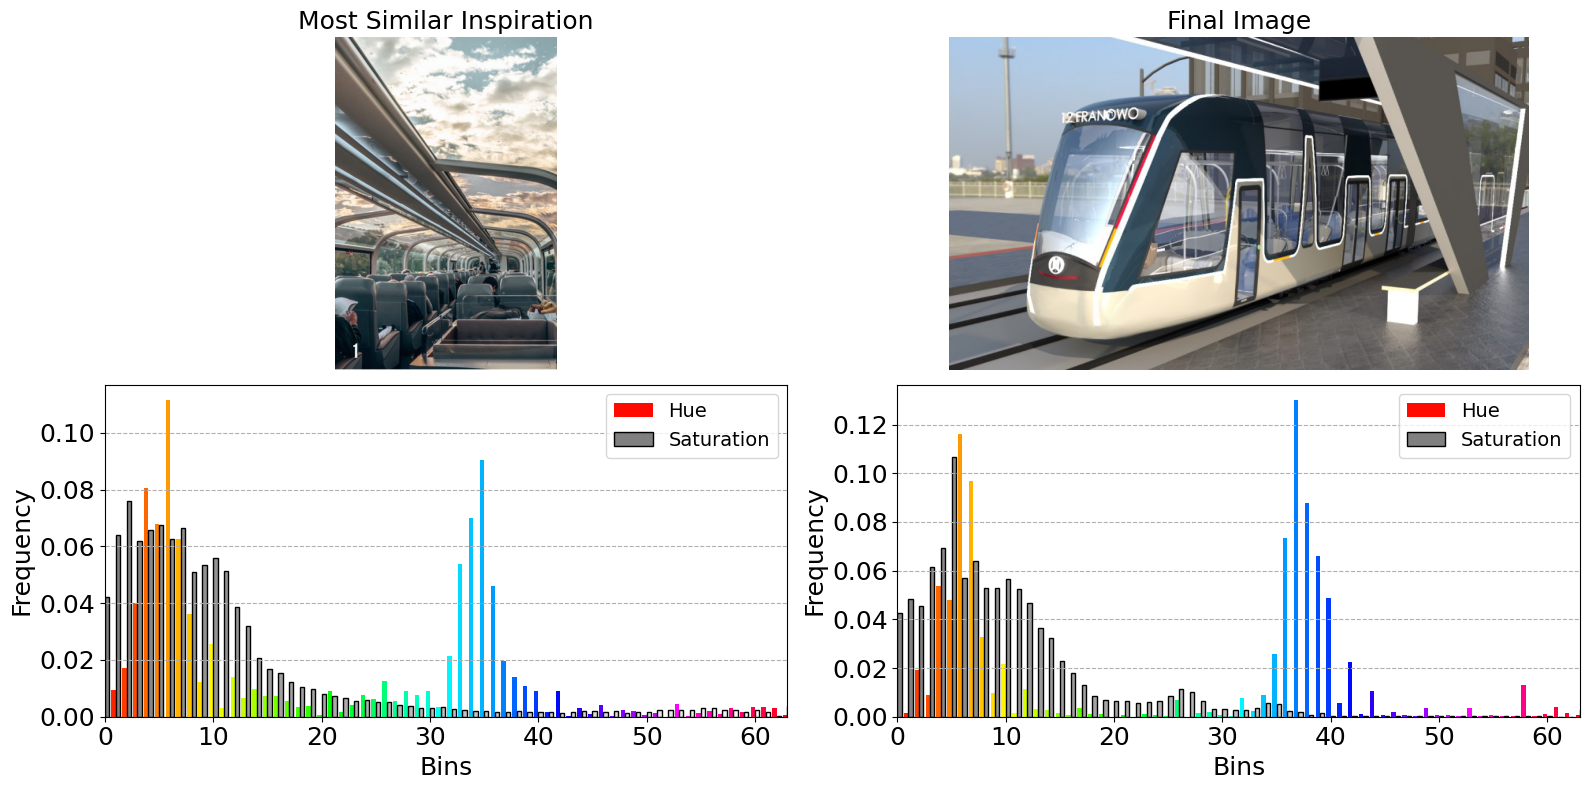

In [18]:
show_example(15, 64, 5)

In [19]:
# group_ids = [i for i in range(8, 26)]
# group_ids.append(27)
# random.shuffle(group_ids)

# for i in range(5):
#     group_id = group_ids[i]
#     show_example(group_id, 64)